In [ ]:
# default_exp macro_econ_parser

In [ ]:
#hide
from nbdev.showdoc import *

# Chapter 3 - macro_econ_parser

> : In this module, I explore how to handle a `Replay`'s `PlayerStatsEnent` data to a player's main macroeconomic indicators during from said match.

## Set up for examples and tests

The following are the module's dependencies.

In [ ]:
#exporti

from pathlib import Path
from pprint import pprint
from dataclasses import dataclass, astuple, field
from datetime import datetime
from typing import *
from fastcore import test as ft

import pandas as pd
import numpy as np

import sc2reader

from sc_training.handle_tracker_event import *


Next, I load a test `Replay` to use as a sample, and test case in this notebook, as `single_replay`. I store a list of all its events as `match_events` and a list of all the tracker events as `tracker_e`.

In [ ]:
rps_path = Path("./test_replays")
game_path = str(rps_path/"Jagannatha LE.SC2Replay")
single_replay = sc2reader.load_replay(game_path)
single_replay

match_events = [event for event in single_replay.events]
tracker_e = [event for event in single_replay.events 
            if isinstance(event, sc2reader.events.tracker.TrackerEvent)]

## PlayerStatsEvents

In this module, I explore how to use a replay's `sc2reader.events.tracker.PlayerStatsEvent` to extract a player's most significant macroeconomic performance indicators.

`PlayerStatsEvent` is a sub-class of the `sc2reader.events.tracker.Envet`class (see 01_handle_tracker_events.ipynb and `handle_tracker_events` module).

These events are generated for each player every ten seconds, regardless of the player's presence in the match. In other words, if one is analysing a match of more than two players and one is defeated, the game still generates `PlayerStatsEvents` for that player up until the end of the match.

Additionally, the game generates a `PlayerStatEvent` when a player leaves (i.e., defeated or surrenders) and when the match ends.

> Note: In 1v1 games, the above behaviour can cause the losing player to have two events generated at the end of the game. One for leaving and one for the end of the game. Source [(Kim, 2015, p. 24)](https://sc2reader.readthedocs.io/en/latest/events/tracker.html)

Note that the sample match lasted 590 seconds. Hence, there should be 59 `PlayerStatEvent`s per player, plus two or three for start and end events. Bellow, I show some important information about the `Replay` that can be useful for debugging and managing these events.

In [ ]:
print(f'{"Game length in seconds:":<27}',
    f'{single_replay.game_length.seconds:>6}')
print(f'{"Game frames per second:":<27}',
    f'{single_replay.game_fps:>6}')
print(f'{"Total frames in the match:":<27}',
    f'{single_replay.game_length.seconds * single_replay.game_fps:>6}')


Game length in seconds:        590
Game frames per second:       16.0
Total frames in the match:  9440.0


Here I extract the `PlayerStatEvent` related to one player in the test match I am analysing.

In [ ]:
p_one_state = [event for event in tracker_e 
               if isinstance(event, sc2reader.events.tracker.PlayerStatsEvent) 
               and event.pid == 1]
print(f'Number of PlayerStatsEvents for player 1: {len(p_one_state)}')


Number of PlayerStatsEvents for player 1: 85


There is a discrepancy in the number of `PlayerStatsEvenst` there should be (59 or 60) and the actual number there is (85).

Similarly, looking at the seconds and frame count registered in the last event, it is clear that they do not match the duration of the game (590 seconds, 9440 frames).

In [ ]:
print(f'Second recorded in the last event: ', 
    f'{p_one_state[len(p_one_state)-1].second}')

print(f'Frame recorded in the last event: ', 
    f'{p_one_state[len(p_one_state)-1].frame}')


Second recorded in the last event:  826
Frame recorded in the last event:  13224


Fortunately, these inconsistencies appear to be the same for all the players. Look at the number of events, the last second and frame registered for Player 2. Note that this player has one less event because he or she was the match's winner.

In [ ]:
p_two_state = [event for event in match_events 
               if isinstance(event, sc2reader.events.tracker.PlayerStatsEvent) 
               and event.pid == 2]

print(f'Number of events recorded for p2: {len(p_two_state)}')

print(f'Second recorded in the last event: ', 
    f'{p_two_state[len(p_two_state)-1].second}')

print(f'Frame recorded in the last event: ', 
    f'{p_two_state[len(p_two_state)-1].frame}')


Number of events recorded for p2: 84
Second recorded in the last event:  826
Frame recorded in the last event:  13224


> Tip: Since this inconsistency affects the recorded time in all TrackerEvents, I defined a `calc_realtime_index` method to address this problem.

Let me plot the graph for one of the most common stats used in the game to measure a player's performance, the army value, in two different ways. I will plot this value with the time registered in the events and with the time index based on the match's duration.

Comparing these two graphs shows how this solution changes the information stored in these events.

In [ ]:
pd.set_option('display.precision', 2)

# Calculate the army value (a_value), adding the amounts of minerals and
# vespene spent in the player's active army at each point during the game.
a_mineral_value = np.array([e.minerals_used_active_forces 
                        for e in  p_one_state])
a_vespene_value = np.array([e.vespene_used_active_forces 
                        for e in  p_one_state])
a_value = a_mineral_value + a_vespene_value

# Generate a DataFrame of the army value at each point in the game using 
# the seconds as an index.
pstats_noprocess = pd.DataFrame({'second': [e.second for e in p_one_state],
                             'army_value': a_value})
pstats_noprocess.set_index('second', inplace=True)
#print(pstats_noprocess.tail(10).to_markdown())

The following table shows the last ten army_value records indexed according to the seconds registered in the `PlayerStatsEvent`.

|   second |   army_value |
|---------:|----------:|
|      750 |         0 |
|      760 |         0 |
|      770 |       350 |
|      780 |         0 |
|      790 |         0 |
|      800 |         0 |
|      810 |       350 |
|      820 |         0 |
|      826 |         0 |
|      826 |         0 |

The following code generates the plot for the army value withthe seconds registered in the `PlayerStatsEvent`s.

<AxesSubplot:xlabel='second'>

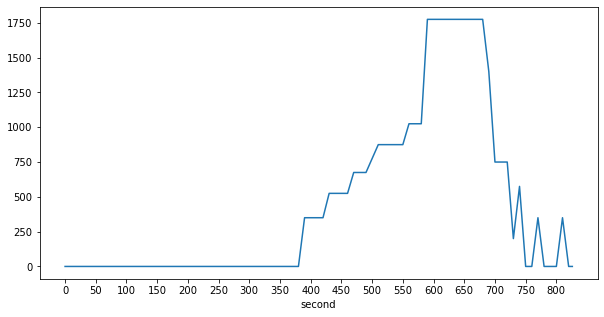

In [ ]:
x_values = [x for x in pstats_noprocess.index if x % 50 == 0]
pstats_noprocess['army_value'].plot(figsize= (10,5), xticks= x_values)

In [ ]:
Next, I recalculate the index of the DataFrame based on the actual duration of the match.

In [ ]:
# Add a column with the new second count to the dataFrame.
# Establish the new second count as index.
pstats_change_seconds = pstats_noprocess.reset_index()
pstats_change_seconds['real_time'] = [calc_realtime_index(event.second, 
                                                          single_replay)
                                      for event in p_one_state]

pstats_change_seconds.set_index('real_time', inplace=True)

# print(pstats_change_seconds.tail(10).to_markdown())

The following table shows the difference in the last ten army_value records between the original time index recorded in the `PlayerStatsEvent` and the time indexes calculated according to replay's length.

|   real_time |   second |   army_value |
|------------:|---------:|-------------:|
|     535.714 |      750 |            0 |
|     542.857 |      760 |            0 |
|     550     |      770 |          350 |
|     557.143 |      780 |            0 |
|     564.286 |      790 |            0 |
|     571.429 |      800 |            0 |
|     578.571 |      810 |          350 |
|     585.714 |      820 |            0 |
|     590     |      826 |            0 |
|     590     |      826 |            0 |

While the difference in the index is notable, note that the form of the graph remains the same.

<AxesSubplot:xlabel='real_time'>

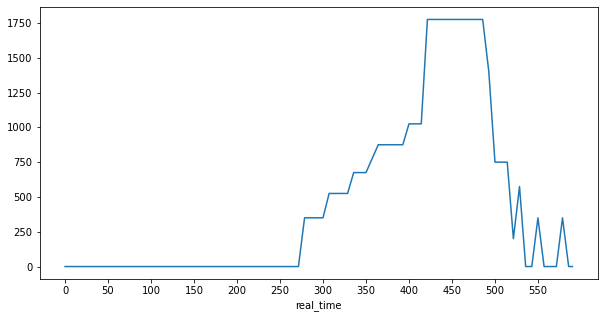

In [ ]:
# Create list of values for the xticks on the plot.
real_x_ticks = np.arange(0,590,50)

# Create the plot with the new time index
pstats_change_seconds['army_value'].plot(figsize= (10,5), xticks= real_x_ticks)

Since the time index is evenly spaced in both cases, there is no change to the curve. However, the timing of the events is different, which one can see using in the graph bellow, where I use the same x_axis from the second graph with the army_values indexed by the original time index.

<AxesSubplot:xlabel='second'>

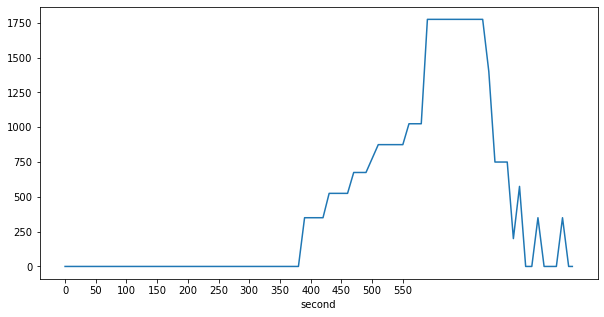

In [ ]:
pstats_noprocess['army_value'].plot(figsize= (10,5), xticks= real_x_ticks)


### Data in `PlayStatsEvent`

Having examined how to manipulate `PlayerStatsEvent` objects, I can examine the type of data they store. In general, this type of objects store macro-economic data.

Here is a list of attributes and how they can be used to compose player stats.

-  `minerals_used_active_forces` and `vespene_used_active_forces`: As I show in the example above, these indicators can be used to calculate the players' army value.
-  `minerals_collection_rate`, `vespene_collection_rate`, `workers_active_count`: are important indicators about the rate of growth of the economy.
- `minerals_current` and `vespene_current`: these attributes can be added and averaged over time to extract the average unspent resources. This information is critical because the game's macro strategy is built around growing an economy and spending resources. Thus, an unspent economy can signal missed opportunities.
- `food_used` and `food_made`: these two attributes can be used to signal moments where the players' supply has been capped. Therefore the player is blocked, preventing players from training units.
- Economy use and lost indicators divide the players' resources into:
    - *used_in_progress*: resources that have been spent in elements (structures, units or research) under development.
        - `minerals_used_in_progress`
        - `vespene_used_in_progress`
        - `resources_used_in_progress`
    - *used_current*: resources invested in elements that are currently in play.
        - `minerals_used_current`
        - `vespene_used_current`
        - `resources_used_current`
    - *lost*: resources invested in elements that a player has lost (by killing or destruction) during the game.
        - `minerals_lost`
        - `vespene_lost`
        - `resources_lost`
    - *killed*: resources that an opponent had invested in elements that the player has killed.
        -  `minerals_killed`
        - `vespene_killed`
        - `resources_killed`
    - Additionally, each mineral and vespene resource attribute has three more associated attributes, providing more detail into the economy. These extended attributes break each indicator into army, economy and technology indicators (buildings, units and research). For example, the `minerals_used_in_progress` attribute has the following attributes that disaggregate it:
        - `minerals_used_in_progress_army`
        - `minerals_used_in_progress_economy`
        - `minerals_used_in_progress_technology`

### Helper Functions

In this module, I define various helper functions that simplify the definition of the module's main exportable functions.
These functions include:

- `get_pstatse` extracts a list of all the `PlayerStatsEvent` instances related to a player from a `Replay`.
- `complete_pstatse_df` expands the initial `DataFrame` that can be extracted directly from the PlayerStatsEvents with several relevant features. I use this function in the `get_player_macro_econ_df` definition.
- `gen_interval_sub_dfs` and `list_attr_interval_values`. These two functions facilitate the division of information so that stats can be calculated based on pandas.DataFrames for the whole match and the early, mid and late intervals of the game.

- Some functions that allow for the functional computation of various indicators:
    - `get_subdf_mean`
    - `get_subdf_total`
    - `calculate_spending_coeficient`

I use these last functions in the `get_player_macro_econ_stats` definition.

> Tip: The implementation of these helper functions can be consulted in the module's development jupyter notebook or source code.


> Note: these functions respond to the functional programming paradigm I am following for this package.

In [ ]:
#exporti

# The Following are the module's helper functions

def get_pstatse(rpl: sc2reader.resources.Replay,
                current_pid: int) \
                -> list[sc2reader.events.tracker.PlayerStatsEvent]:
    """Extracts a list of all the `PlayerStatsEvent` instances related to
    a player from a replay.

    *Args*
        - rpl (sc2reader.resources.Replay)
            The replay that contains the information.
        - current_pid (int):
            The player id of the player who's events are being extracted.

    *Retruns*
        - lis[PlayerStatsEvent]
            List of all the `PlayerStatsEvent` instances of a player in a
            replay.
    """

    return [event for event in rpl.events
            if isinstance(event, sc2reader.events.tracker.PlayerStatsEvent)
            and event.pid == current_pid]

In [ ]:
#exporti

def complete_pstatse_df(rpl: sc2reader.resources.Replay,
                        df: pd.DataFrame) -> pd.DataFrame:
    """Expands the initial DataFrame that can be extracted directly from
    the PlayerStatsEvents with several relevant features.

    This function uses the replay data to compose several features time
    series that can facilitate the extraction of macroeconomic stats later.
    The function adds the following columns to the macroeconomic stats
    DataFrame extracted from the PlayerStatsEvents: real_time (realtime
    indexes that match the replay duration), unspent_rsrc,
    rsrc_collection_rate.

    *Args*
        - rpl (sc2reader.resources.Replay)
            Working replay.
        - df (pd.DataFrame)
            DataFrame containing the data on the main macroeconomic
            indicators recorded in the Replay's the PlayerStatsEvents.

    *Returns*
        - pd.DataFrame
            Expanded DataFrame that includes all relevant data about a
            replay's macroeconomic indicators.

    """
    # Eliminate the record of the loser record if present.
    if (df.iloc[-1] == df.iloc[-2]).all():
        df_no_loss_record = df.drop([len(df)-1])
    else:
        df_no_loss_record = df.copy()

    # Get the last recorded time in the dataframe
    last_time_record = df_no_loss_record.iloc[-1].second

    # Calculate the values for the real time column
    real_time_indexes = [calc_realtime_index(rec_time_ind, rpl)
                         for rec_time_ind in df_no_loss_record.second]

    # Add the real_time indexes column to the data frame
    df_no_loss_record.insert(0,'real_time', real_time_indexes)

    # Add columns for extra features
    df_no_loss_record.insert(4,'unspent_rsrc',
                            (df_no_loss_record.minerals_current 
                            + df_no_loss_record.vespene_current))
    df_no_loss_record.insert(7,'army_value',
                            (df_no_loss_record.minerals_used_active_forces 
                            +df_no_loss_record.vespene_used_active_forces))
    df_no_loss_record.insert(10,'rsrc_collection_rate',
                            (df_no_loss_record.minerals_collection_rate 
                            + df_no_loss_record.vespene_collection_rate))

    supply_capped_column = np.where(df_no_loss_record['food_made'] <=
                                    df_no_loss_record['food_used'],
                                    True, False)
                                    
    df_no_loss_record.insert(26, 'supply_capped', supply_capped_column)
    return df_no_loss_record

In [ ]:
#export

def gen_interval_sub_dfs(rpl_length: float,
                        df: pd.DataFrame, column: str) -> pd.DataFrame:
    """Extract a set of DataFrames containing the records for a particular
    field of the PlayerStatsEvent.

    The function extracts the information of a particular column of the df
    DataFrame. It returns a list of four DataFrames for the whole, early,
    mid and late game intervals.

    *Args*
        - df (pd.DataFrame)
            DataFrame containing all PlayerStatsEvent instances of a
            replay.
        - rpl_length (float)
            Length of a match in seconds.
        - column (str)
            Name of the column that should be extracted in the DataFrames

    *Returns*
        - list[DataFrame]
            List of the DataFrames, containing the column information for
            the whole, early, mid and late games in that order.
    """
    process_df = df.copy()
    early_mark = INTERVALS_BASE
    mid_mark = early_mark * 2
    late_mark = rpl_length


    if rpl_length > mid_mark:
        time_intervals = [(0, rpl_length), (0, early_mark),
                         (early_mark, mid_mark), (mid_mark, rpl_length)]

    elif early_mark < rpl_length <= mid_mark:
        time_intervals = [(0, rpl_length), (0, early_mark),
                         (early_mark, rpl_length), None]

    elif 0 < rpl_length <= early_mark:
        time_intervals = [(0, rpl_length), (0, rpl_length), None, None]


    sub_dfs = [process_df[column].loc[process_df.real_time.between(*interval)]
               if interval != None else pd.DataFrame()
               for interval in time_intervals]

    return sub_dfs

In [ ]:
#exporti
# Functions for specific indicators
def get_subdf_mean(subdf: pd.DataFrame) -> float:
    """Wraper for the pd.DataFrame.mean() function.

    *Args*
        -subdf (pd.DataFrame)
               This is the DatraFrame whos mean will be evaluated.

    *Returns*
        - float
            Mean value of the DataFrame.
    """
    return subdf.mean()

def get_subdf_total(subdf: pd.DataFrame) -> float:
    """Wraper for the pd.DataFrame.mean() function.

    *Args*
        -subdf (pd.DataFrame)
               This is the DatraFrame whos mean will be evaluated.

    *Returns*
        - float
            Total value of a particular attribute up to a certain point of
            the game.
    """
    return subdf.iloc[len(subdf)-1]

def get_cappedTime(subdf:pd.DataFrame) -> float:
    lapse_start = 0
    capped_lapses = []

    # Verify row by row if at the time the supply was capped.
    # Add a time lapse to the capped_lapses list every time concludes.
    for _, row in subdf.iterrows():
        if row['supply_capped']:
            if not lapse_start:
                lapse_start = row['real_time']
        else:
            if lapse_start:
                capped_lapses.append(row['real_time'] - lapse_start)
                lapse_start = 0

    # Verify if the interval finished capped. If so, account
    # for the lapse.
    if lapse_start:

        last_event_length = (subdf.iloc[-1]['real_time']
                             - subdf.iloc[-2]['real_time'])
        capped_lapses.append(subdf.iloc[-1]['real_time']
                             - lapse_start + last_event_length)

    return sum(capped_lapses)


def calculate_spending_coeficient(unspent_rsrc: float,
                                  total_rates: float) -> float:
    if unspent_rsrc and total_rates:
        return (35*((0.00137*total_rates) - np.log(unspent_rsrc)) + 240)
    else:
        return None

In [ ]:
#export

def list_attr_interval_values(df: pd.DataFrame,
                            func: Callable[[pd.DataFrame], Any],
                            df_attribute: str, rpl_length: float) -> list[Any]:
    """Lists the result of a function it receives applied to the values of
    various listed DataFrames.

    This function receives a DataFrame, splits it into sub-DataFrames based
    on various game intervals, and then applies a function to those
    intervals listing the results.

    *Args*
        - df (pandas.DataFrame)
            A DataFrame of various attributes of a replay, including those
            that must be processed.
        - func (callable)
            A function that will be applied to each interval
        - df_attribute (str)
            Name of the DataFrame's attribute (i.e. column) to which the
            function must be applied.
        - rpl_length (float)
            The duration of the Replay from which the DataFrame is
            constructed in seconds.

    *Returns*
        -  List of the return values of the function func applied to the
        various game intervals.

    """
    return [func(subdf) if not subdf.empty else None
            for subdf in gen_interval_sub_dfs(rpl_length, df, df_attribute)]

### Macroeconomic Stats Functions

Here, I define two functions that can expand each player's performance information in specific matches.

The first function, `get_player_macro_econ_df` uses pandas to extract the significant indicator from the `PlayerStatsEvents`, reorganising them in a `pandas.DataFrame`. This `DataFrame` expands the information in these events with several columns. Chiefly, the data frame includes a `real_time`column that allows for the correct indexing of the events based on the match's duration.

The second function, `get_player_macro_econ_stats` uses the information in the DataFrames produced with `get_player_macro_econ_df` to calculate multiple macroeconomic performance indicators for each player in a match.

In [ ]:
#export

def get_player_macro_econ_df(rpl: sc2reader.resources.Replay,
                             pid: int) -> pd.DataFrame:
    """This function organises the records of a player's major
    macroeconomic performance indicators.

    The function uses a player's PlayerStatsEvents contained in a Replay
    object to compose a DataFrame. In the DataFrame, each column points to
    a particular indicator. Each row points to the records of all
    indicators at a specific moment during the game.

    *Arguments*
        - rpl (sc2reader.resources.Replay)
                Replay object generated with sc2reader containing a match's
                data.
        - pid (int)
                A player's id number distinguishes them from the other
                players in a match. It can be extracted from a Participant
                object through the pid attribute.

    *Returns*
        - pd.DataFrame
            This DataFrame contains all the time series that illustrate the
            changes of each attribute during a match. Each column alludes
            to an attribute, each row to a moment during the match.
    """

    columns_names =[
    'second',
    'minerals_current',
    'vespene_current',
    'minerals_used_active_forces',
    'vespene_used_active_forces',
    'minerals_collection_rate',
    'vespene_collection_rate',
    'workers_active_count',
    'minerals_used_in_progress',
    'vespene_used_in_progress',
    'resources_used_in_progress',
    'minerals_used_current',
    'vespene_used_current',
    'resources_used_current',
    'minerals_lost',
    'vespene_lost',
    'resources_lost',
    'minerals_killed',
    'vespene_killed',
    'resources_killed',
    'food_used',
    'food_made'
    ]

    # Generate a DataFrame with the columns listed above
    pstatse_list = get_pstatse(rpl, pid)
    pstatse_dicts_list = [event.__dict__ for event in pstatse_list]
    pstatse_df = pd.DataFrame(pstatse_dicts_list, columns= columns_names)

    # Complete the DataFrame with the real_time, unspent_rsrc columns and
    # army_value.
    # Also, eliminate possible duplicate last record.
    return complete_pstatse_df(rpl, pstatse_df)

The `get_player_macro_econ_df` function organises a player's `PlayerStatsEvents` into a `DataFrame` where the columns represent each indicators' values. In said  `DataFrame` the rows represent the player's events.

The code below shows the recorded data for the last event (i.e. row) of the DataFrame extracted from a sample replay using this function.

In [ ]:
test_df = get_player_macro_econ_df(single_replay, 1)
print(test_df.iloc[-1])

real_time                      590.0
second                           826
minerals_current                2750
vespene_current                  996
unspent_rsrc                    3746
minerals_used_active_forces        0
vespene_used_active_forces         0
army_value                         0
minerals_collection_rate        1455
vespene_collection_rate          447
rsrc_collection_rate            1902
workers_active_count              41
minerals_used_in_progress          0
vespene_used_in_progress           0
resources_used_in_progress         0
minerals_used_current           3875
vespene_used_current               0
resources_used_current          3875
minerals_lost                   5000
vespene_lost                    1250
resources_lost                  6250
minerals_killed                  900
vespene_killed                   125
resources_killed                1025
food_used                       41.0
food_made                       39.0
supply_capped                   True
N

In [ ]:
#export

def get_player_macro_econ_stats(rpl: sc2reader.resources.Replay, 
                                pid: int)-> dict:
    """This function organises a player's major macroeconomic performance
    indicatorsinto a dictionary.

    The function uses a player's PlayerStatsEvents in a Replay object to
    calculate the player's major economic performance indicators. These
    indicators are calculated for the whole game, as well as for the early
    (first 4 minutes), mid (between minutes 4 and 8) and
    late games (paste minute 8).

    **Arguments**
        - rpl (sc2reader.resources.Replay)
                Replay object generated with sc2reader containing a match's
                data.
        - pid (int)
                A player's id number distinguishes them from the other
                players in a match. It can be extracted from a Participant
                object through the pid attribute.

    **Returns**
        - dict
            This dictionary contains the values for a player's major
            macroeconomic performance indicators. Each indicator is
            calculated for the entire game and the early, mid and late
            game intervals.
    """

    replay_info = {'replay_name': rpl.filename,
                'player_username': rpl.player[pid].name,
                'player_id': pid}

    rpl_length = rpl.length.seconds
    pstatse_complete_df = get_player_macro_econ_df(rpl, pid)

    # I use the following list of tuples to direct the generation of the
    # macroeconomic indicators based on the comluns of the replay's df.
    # Each tuple has three values:
    #   - The name used as a key to store the value in the macroeconomic
    #     stats dictionary returned by this function
    #   - The name of the indicator's column in the replay's DataFrame
    #   - The function that must be used to transform the values of the
    #     latter column in the DataFrame into a single value stored with
    #     the former key in the dictionary.

    main_indicators_params = [
                    ('unspent_minerals_avg', 'minerals_current',
                     get_subdf_mean),
                    ('unspent_vespene_avg', 'vespene_current',
                     get_subdf_mean),
                    ('unspent_resources_avg', 'unspent_rsrc',
                     get_subdf_mean),
                    ('active_workers_avg', 'workers_active_count',
                     get_subdf_mean),
                    ('mineral_collection_rate_avg',
                     'minerals_collection_rate',
                      get_subdf_mean),
                    ('vespene_collection_rate_avg',
                     'vespene_collection_rate',
                     get_subdf_mean),
                    ('resource_collection_rate_avg',
                     'rsrc_collection_rate',
                     get_subdf_mean),
                    ('army_value_avg', 'army_value', get_subdf_mean),
                    ('lost_minerals_totals', 'minerals_lost',
                     get_subdf_total),
                    ('lost_vespene_totals', 'vespene_lost',
                     get_subdf_total),
                    ('time_supply_capped', ['real_time', 'supply_capped'],
                     get_cappedTime)
                    ]

    # Run the functions to build dict
    indicator_groups = {k: list_attr_interval_values(pstatse_complete_df,
                                                     func, attr,
                                                     rpl_length)
                        for (k, attr, func)
                        in main_indicators_params}



    # Add a column for the spending qs value. This is compute separately,
    # because its values do not depend on the DataFrame, but in the
    # indicators dictionaries.
    indicator_groups['spending_qs'] = [
                    calculate_spending_coeficient(unspent, col_rate)
                    for unspent, col_rate
                    in zip(indicator_groups['unspent_resources_avg'],
                           indicator_groups['resource_collection_rate_avg'])
                    ]

    game_intervals = ['whole', 'early', 'mid', 'late']

    attr_full_list = {f'{k}_{interval}':v[game_intervals.index(interval)]
                      for k, v in indicator_groups.items()
                      for interval in game_intervals}

    replay_info.update(attr_full_list)

    return replay_info

The indicators extracted with this function include:

- Average unspent minerals, vespene and minerals
- Average Active Workers
- Average mineral, vespene and resource collection rate
- Average army value
- Total minerals and vespene lost
- Spending Quotient

Note that the spending quotient is a performance measurement that the community has adopted to compare and evaluate a player's macroeconomic performance ([whatthefat, 2011](https://tl.net/forum/starcraft-2/266019-do-you-macro-like-a-pro); [Spending Quotient, 2020](https://liquipedia.net/starcraft2/Spending_quotient)).

Moreover, I calculate each of these indicators for the entire match and the early (first 4 minutes), mid (minutes 4-8) and late game (past minute 8).

The following are three sample results of this function used on a short, medium and long replays of the same player.

In [ ]:
pprint(get_player_macro_econ_stats(single_replay, 1), sort_dicts=False)

{'replay_name': 'test_replays\\Jagannatha LE.SC2Replay',
 'player_username': 'HDEspino',
 'player_id': 1,
 'unspent_minerals_avg_whole': 607.2619047619048,
 'unspent_minerals_avg_early': 348.0882352941176,
 'unspent_minerals_avg_mid': 441.7647058823529,
 'unspent_minerals_avg_late': 1509.6875,
 'unspent_vespene_avg_whole': 197.04761904761904,
 'unspent_vespene_avg_early': 35.470588235294116,
 'unspent_vespene_avg_mid': 170.52941176470588,
 'unspent_vespene_avg_late': 596.75,
 'unspent_resources_avg_whole': 804.3095238095239,
 'unspent_resources_avg_early': 383.55882352941177,
 'unspent_resources_avg_mid': 612.2941176470588,
 'unspent_resources_avg_late': 2106.4375,
 'active_workers_avg_whole': 26.678571428571427,
 'active_workers_avg_early': 16.5,
 'active_workers_avg_mid': 30.941176470588236,
 'active_workers_avg_late': 39.25,
 'mineral_collection_rate_avg_whole': 1106.6785714285713,
 'mineral_collection_rate_avg_early': 770.6764705882352,
 'mineral_collection_rate_avg_mid': 1243.3529

In [ ]:
short_rpl = sc2reader.load_replay('./test_replays/Oxide LE (12).SC2replay')
long_rpl = sc2reader.load_replay('./test_replays/Blackburn LE (2).SC2replay')

In [ ]:
pprint(get_player_macro_econ_stats(short_rpl, 1), sort_dicts=False)

{'replay_name': './test_replays/Oxide LE (12).SC2replay',
 'player_username': 'HDEspino',
 'player_id': 1,
 'unspent_minerals_avg_whole': 163.9189189189189,
 'unspent_minerals_avg_early': 155.0,
 'unspent_minerals_avg_mid': 265.0,
 'unspent_minerals_avg_late': None,
 'unspent_vespene_avg_whole': 154.59459459459458,
 'unspent_vespene_avg_early': 126.47058823529412,
 'unspent_vespene_avg_mid': 473.3333333333333,
 'unspent_vespene_avg_late': None,
 'unspent_resources_avg_whole': 318.5135135135135,
 'unspent_resources_avg_early': 281.47058823529414,
 'unspent_resources_avg_mid': 738.3333333333334,
 'unspent_resources_avg_late': None,
 'active_workers_avg_whole': 19.054054054054053,
 'active_workers_avg_early': 18.705882352941178,
 'active_workers_avg_mid': 23.0,
 'active_workers_avg_late': None,
 'mineral_collection_rate_avg_whole': 697.5405405405405,
 'mineral_collection_rate_avg_early': 693.2941176470588,
 'mineral_collection_rate_avg_mid': 745.6666666666666,
 'mineral_collection_rate_av

In [ ]:
pprint(get_player_macro_econ_stats(long_rpl, 2), sort_dicts=False)

{'replay_name': './test_replays/Blackburn LE (2).SC2replay',
 'player_username': 'HDEspino',
 'player_id': 2,
 'unspent_minerals_avg_whole': 1435.680473372781,
 'unspent_minerals_avg_early': 205.88235294117646,
 'unspent_minerals_avg_mid': 688.9705882352941,
 'unspent_minerals_avg_late': 2101.039603960396,
 'unspent_vespene_avg_whole': 326.9585798816568,
 'unspent_vespene_avg_early': 41.411764705882355,
 'unspent_vespene_avg_mid': 275.2352941176471,
 'unspent_vespene_avg_late': 440.4950495049505,
 'unspent_resources_avg_whole': 1762.6390532544378,
 'unspent_resources_avg_early': 247.2941176470588,
 'unspent_resources_avg_mid': 964.2058823529412,
 'unspent_resources_avg_late': 2541.5346534653463,
 'active_workers_avg_whole': 33.142011834319526,
 'active_workers_avg_early': 17.88235294117647,
 'active_workers_avg_mid': 33.794117647058826,
 'active_workers_avg_late': 38.05940594059406,
 'mineral_collection_rate_avg_whole': 1121.3254437869823,
 'mineral_collection_rate_avg_early': 801.1470

## References

- Kim, G. (2015) 'sc2reader Documentation'. Available at: https://sc2reader.readthedocs.io/_/downloads/en/latest/pdf/.
- Spending Quotient (2020) Liquipedia - The StarCraft II Encyclopedia. Available at: https://liquipedia.net/starcraft2/Spending_quotient (Accessed: 18 June 2021).
- whatthefat (2011) Do you macro like a pro?, TL.net blog. Available at: https://tl.net/forum/starcraft-2/266019-do-you-macro-like-a-pro (Accessed: 18 June 2021).


In [ ]:
# #hide
# from nbdev.export import notebook2script
# notebook2script()

Converted 01_summarise_rpl.ipynb.
Converted 02_handle_tracker_events.ipynb.
Converted 03_macro_econ_parser.ipynb.
Converted 04_build_parser.ipynb.
Converted 05_handle_game_events.ipynb.
Converted index.ipynb.
